In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utilities
from tools import load_json
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Initial setup

In [2]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load IZA cantons
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=1, dtype=int)
n_iza = len(iza_cantons)

In [4]:
deem_dir = '../../Processed_Data/DEEM_330k/Data'
iza_dir = '../../Processed_Data/IZA_230/Data'

# Linear regression of molar volumes and energies

## Deem 10k train set

In [5]:
# Load train and test set indices for Deem
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test.idxs', dtype=int)
n_deem_train = len(deem_train_idxs)
n_deem_test = len(deem_test_idxs)

In [6]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_structure_properties = {}
deem_predicted_structure_properties = {}

iza_structure_properties = {}
iza_predicted_structure_properties = {}
for pn in property_names:
    property_label = pn.capitalize()
    
    deem_structure_properties[pn] = np.loadtxt(f'{deem_dir}/structure_{pn}.dat')
    iza_structure_properties[pn] = np.loadtxt(f'{iza_dir}/structure_{pn}.dat')
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')

In [7]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.40	2.81
IZA:	--	230	--	5.30

IZA1:	--	36	--	4.54
IZA2:	--	125	--	5.17
IZA3:	--	68	--	5.38
IZA4:	--	1	--	44.28

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.62	0.65
IZA:	--	230	--	0.92

IZA1:	--	36	--	0.98
IZA2:	--	125	--	0.88
IZA3:	--	68	--	0.94
IZA4:	--	1	--	2.02

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.03	1.10
IZA:	--	230	--	1.70

IZA1:	--	36	--	0.96
IZA2:	--	125	--	1.57
IZA3:	--	68	--	1.91
IZA4:	--	1	--	30.52

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.15	0.19
IZA:	--	230	--	0.18

IZA1:	--	36	--	0.14
IZA2:	--	125	--	0.15
IZA3:	--	68	--	0.23
IZA4:	--	1	--	1.97



## Deem random train set

In [8]:
# Load train and test set indices for Deem
deem_train_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train_random.idxs', dtype=int)
deem_test_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test_random.idxs', dtype=int)
n_deem_train = len(deem_train_idxs_random)
n_deem_test = len(deem_test_idxs_random)

In [9]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_predicted_structure_properties = {}
iza_predicted_structure_properties = {}
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')

In [10]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs_random]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs_random]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.46	2.42
IZA:	--	230	--	5.06

IZA1:	--	36	--	4.53
IZA2:	--	125	--	4.75
IZA3:	--	68	--	5.21
IZA4:	--	1	--	51.98

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.62	0.64
IZA:	--	230	--	0.90

IZA1:	--	36	--	0.98
IZA2:	--	125	--	0.85
IZA3:	--	68	--	0.93
IZA4:	--	1	--	3.22

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.06	1.05
IZA:	--	230	--	1.64

IZA1:	--	36	--	0.85
IZA2:	--	125	--	1.50
IZA3:	--	68	--	1.88
IZA4:	--	1	--	31.91

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.16	0.20
IZA:	--	230	--	0.18

IZA1:	--	36	--	0.15
IZA2:	--	125	--	0.17
IZA3:	--	68	--	0.18
IZA4:	--	1	--	3.28



## DEEM 330k analysis

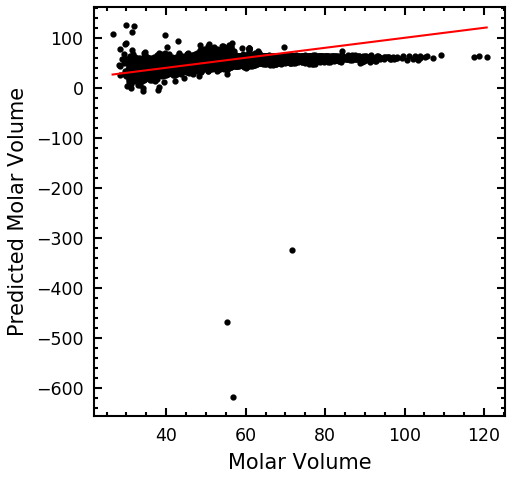

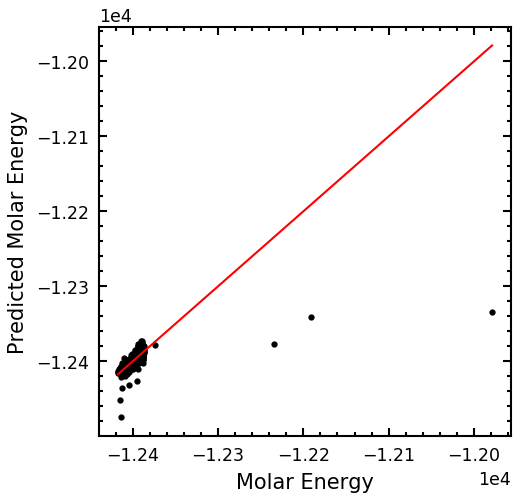

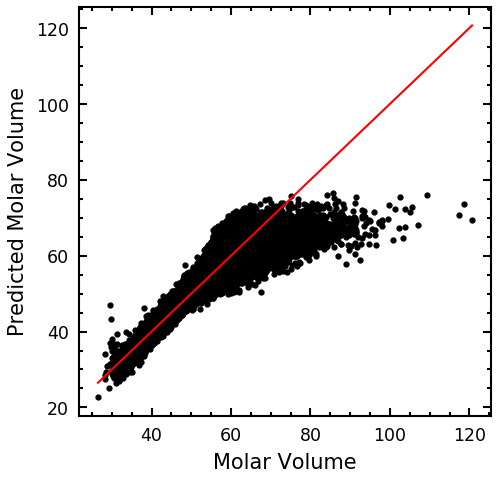

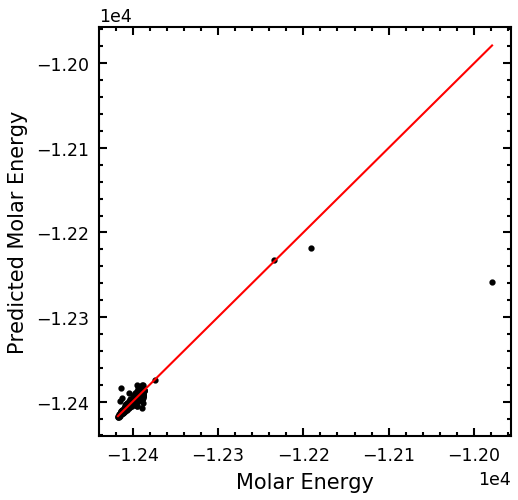

In [11]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        plt.scatter(
            deem_structure_properties[pn], 
            deem_predicted_structure_properties[cutoff][pn]
        )
        plt.plot(
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.show()

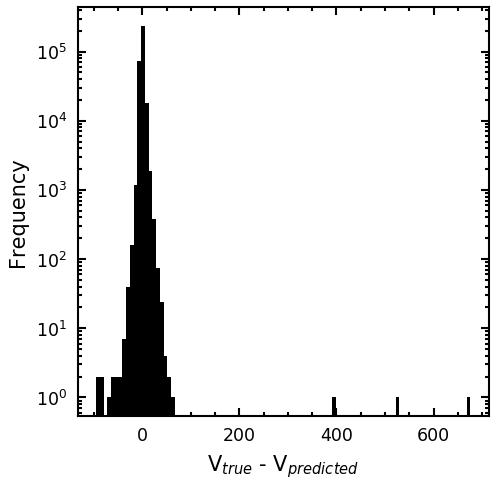

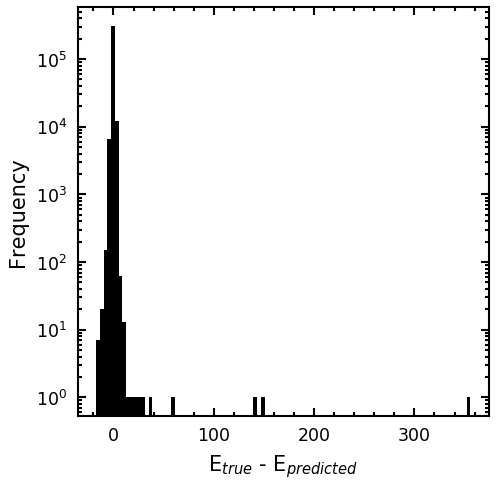

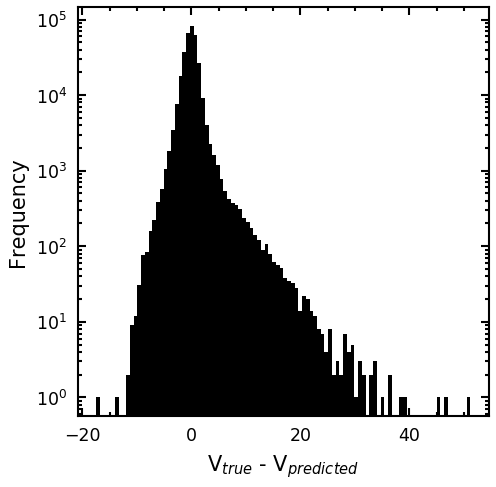

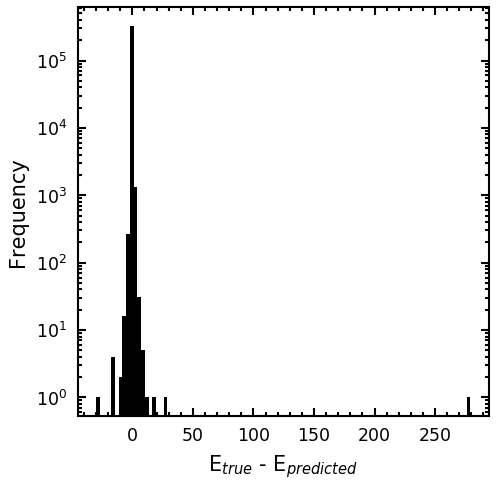

In [12]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [13]:
deem_codes = np.arange(0, len(deem_structure_properties['volumes'])) + 8000001

In [14]:
n_show = 100
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c in zip(errors[idxs][-n_show:], deem_codes[idxs][-n_show:]):
            print(f'{c}\t\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
8267043		30.412977902027087
8328225		30.41420272459461
8248695		30.442465209684315
8037822		30.454665494441414
8068129		30.461566277882703
8079879		30.47056833945677
8028083		30.59921821062948
8325400		30.61156102053795
8327932		30.766771210138778
8316033		30.780947943372574
8129594		30.97905105765897
8307137		31.0689738530494
8311326		31.154938810815445
8274922		31.39728255225345
8307691		31.640362463931005
8325055		31.650159600406873
8308288		31.81791288161549
8035895		31.8294239959028
8318835		31.95103417288521
8329775		31.960606690467827
8317652		31.96661580997184
8319194		32.07189650674212
8312657		32.09911039037763
8249662		32.206868571736
8116204		32.252303285512404
8200851		32.48660172764332
8323191		32.554406185090585
8320103		32.56702592970008
8327293		32.625982976822776
8307129		32.95735021376431
8261270		33.005217330290805
8326900		33.226097284973065
8037824		33.33438988730764
8200684		33.4768838077478
8327476		33.52792264320912
8320054

In [15]:
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)
deem_delete_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [16]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        print(f'-----Problem structures for {cutoff} {pn}-----')
        for i in range(1, 11):
            idxs_high = np.nonzero(errors >= mean_error + i * std_error)[0]
            idxs_low = np.nonzero(errors <= mean_error - i * std_error)[0]
            idxs_all = np.concatenate((idxs_low, idxs_high))
            in_deem_10k = np.intersect1d(deem_10k_idxs, idxs_all)
            in_deem_delete = np.intersect1d(deem_delete_idxs, idxs_all)
            for idxs in (idxs_all, in_deem_10k, in_deem_delete):
                idxs += 8000001
            print(f'{i}-sigma ({len(idxs_all)}, {len(in_deem_delete)}, {len(in_deem_10k)})')
            print(idxs_all)
        print('')

-----Problem structures for 3.5 volumes-----
1-sigma (29896, 3, 855)
[8000008 8000022 8000028 ... 8331161 8331163 8331164]
2-sigma (9118, 3, 256)
[8000022 8000070 8000097 ... 8331136 8331156 8331164]
3-sigma (3775, 3, 102)
[8000022 8000070 8000202 ... 8331120 8331121 8331135]
4-sigma (1933, 3, 59)
[8000022 8001711 8001755 ... 8331110 8331120 8331121]
5-sigma (1043, 3, 38)
[8001711 8002590 8003329 ... 8330856 8330907 8331121]
6-sigma (557, 3, 16)
[8001711 8004390 8007299 8009564 8014803 8016387 8022741 8026995 8027927
 8028083 8028375 8035701 8035895 8037822 8037824 8037968 8038078 8038300
 8038314 8042929 8045218 8045577 8045578 8045580 8047564 8047801 8048032
 8050952 8054009 8054159 8055726 8055999 8056680 8056798 8056809 8056820
 8056830 8059332 8059343 8059805 8062817 8063080 8067891 8067892 8067893
 8068115 8068129 8069913 8077929 8079879 8104566 8112360 8116179 8116180
 8116204 8116280 8116310 8116413 8116420 8116470 8116490 8116509 8116522
 8116542 8116546 8116548 8116571 811658

## IZA 230 analysis

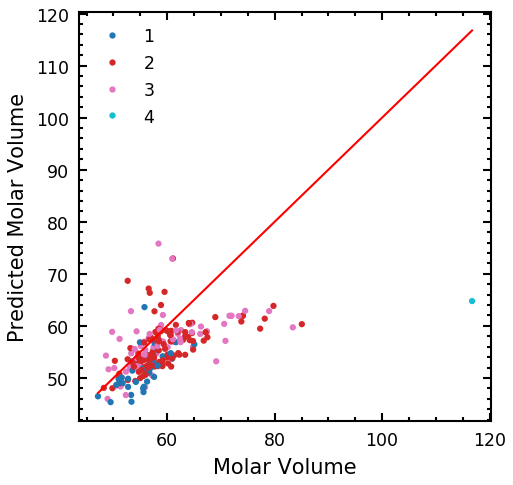

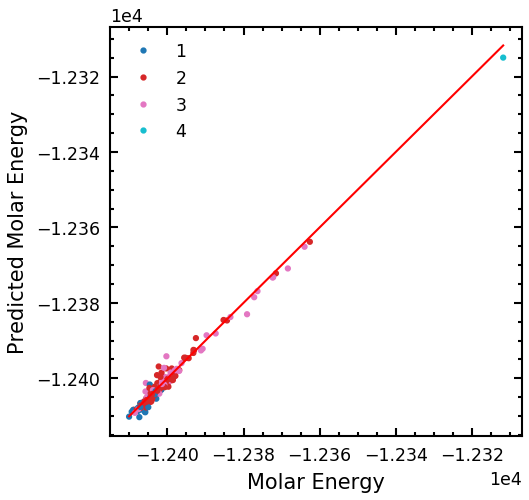

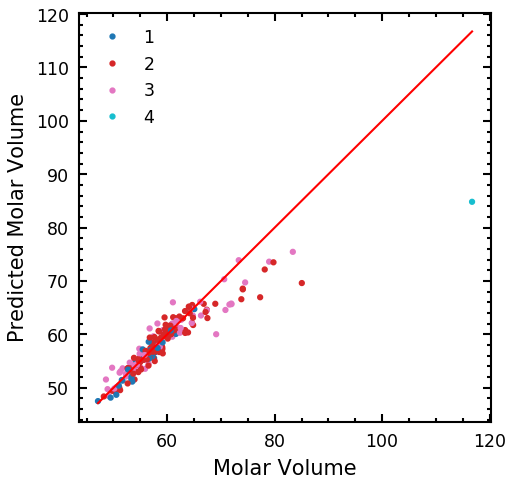

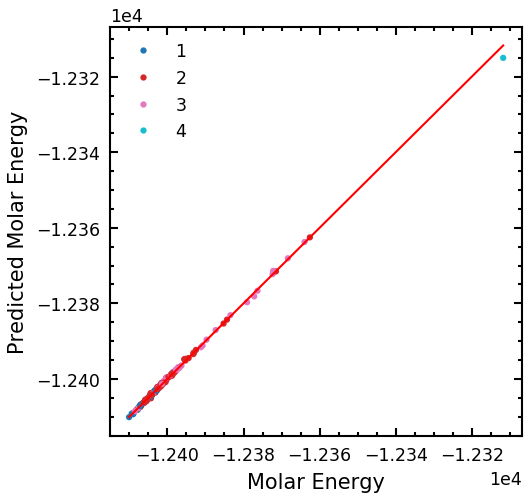

In [17]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        scatter = plt.scatter(
            iza_structure_properties[pn], 
            iza_predicted_structure_properties[cutoff][pn],
            c=iza_cantons, cmap='tab10'
        )
        plt.plot(
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.legend(*scatter.legend_elements())
        plt.show()

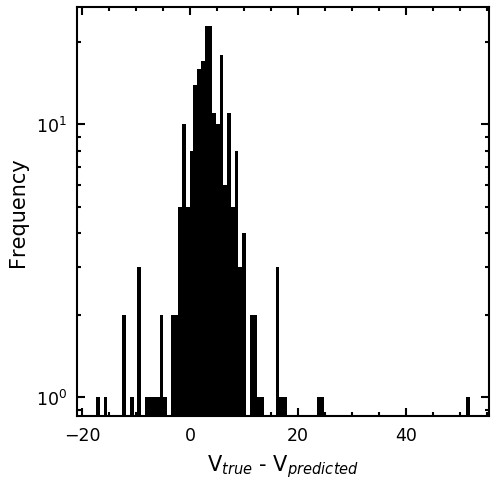

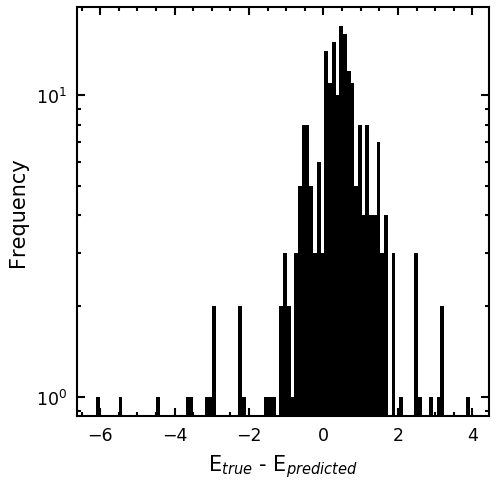

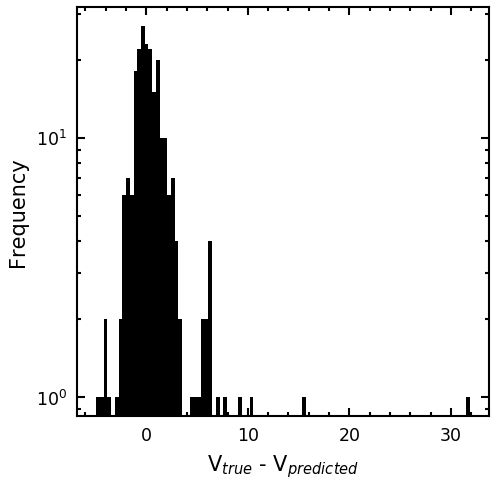

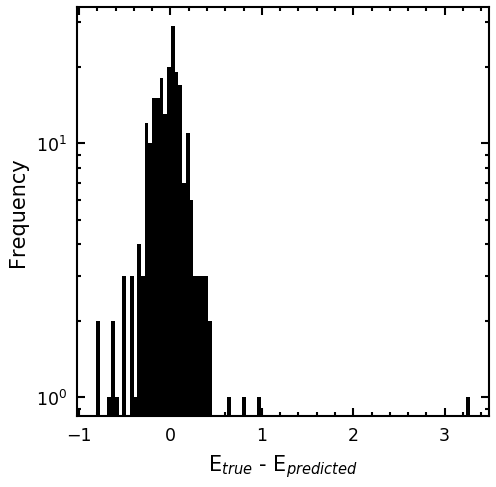

In [18]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            iza_structure_properties[pn] - iza_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [19]:
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=0, dtype=str)

In [20]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(iza_structure_properties[pn] -  iza_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c, cc in zip(errors[idxs], iza_cantons[idxs], iza_codes[idxs]):
            print(f'{c}\t{cc[0:3]}\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
2	BRE	0.060360255711437105
2	STI	0.0971038436081102
2	MVY	0.09858024234186757
2	PHI	0.1413210195752157
1	ETL	0.1530600549271739
2	SOR	0.16494628271883727
2	JBW	0.26344407533736103
3	DFT	0.45563123489078095
2	SOF	0.4857017278764033
3	POR	0.5718464546681545
3	SIV	0.6023125550715207
1	MTF	0.6417209831909219
2	ABW	0.6900388712624732
2	LTL	0.7074298048779468
2	MRT	0.713603179608107
2	ETV	0.8209534541661228
2	MSO	0.8345448858726598
2	LAU	0.8379736259472352
3	BOF	0.9070160282448754
2	SZR	0.9108294984285195
3	AHT	0.9357992841253946
2	LTJ	0.958024975160896
1	LTF	0.9587538672764211
2	LOV	1.0138533607836564
2	CAS	1.0234545511824322
2	MOZ	1.025120042248922
2	VNI	1.0494310038812742
3	APC	1.0552264522567896
2	MWF	1.085774264022902
2	GIS	1.089271199078162
3	ATT	1.1182074213374449
3	JRY	1.1187874674767855
3	ATN	1.2544188031429329
3	AFN	1.2554367607256438
3	ACO	1.2943941358776883
3	ZON	1.3064536786064522
1	NSI	1.3147353074065222
3	JSN	1.3491279281947826
2	MAZ	1.403

# Linear regression of IZA compositions

In [5]:
# Load train and test set indices for IZA
iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
# iza_train_idxs = iza_train_idxs[iza_cantons[iza_train_idxs] != 3]
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
# iza_test_idxs = np.concatenate((iza_test_idxs, iza_train_idxs[iza_cantons[iza_train_idxs] == 3]))
n_iza_train = len(iza_train_idxs)
n_iza_test = len(iza_test_idxs)

In [6]:
# Set property names for loading
property_name = 'composition'
property_label = property_name.capitalize()

# Load structure properties
iza_compositions = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=2)
iza_predicted_compositions = {}
    
for cutoff in cutoffs:
    iza_predicted_compositions[cutoff] = np.loadtxt(
        f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat'
    )

In [7]:
for cutoff in cutoffs:
    print(f'-----Error for {cutoff} {property_label}-----')
    print('DATASET | n_train | n_test | train_error | test_error')

    iza_train_error = mean_absolute_error(
        iza_compositions[iza_train_idxs],
        iza_predicted_compositions[cutoff][iza_train_idxs]
    )

    iza_test_error = mean_absolute_error(
        iza_compositions[iza_test_idxs],
        iza_predicted_compositions[cutoff][iza_test_idxs]
    )

    print(f'IZA:\t{n_iza_train}\t{n_iza_test}\t{iza_train_error:.2f}\t{iza_test_error:.2f}')
    print('')

    for canton in range(1, np.amax(iza_cantons)+1):
        canton_train_idxs = np.nonzero(iza_cantons[iza_train_idxs] == canton)[0]
        canton_test_idxs = np.nonzero(iza_cantons[iza_test_idxs] == canton)[0]
        n_canton_train = len(canton_train_idxs)
        n_canton_test = len(canton_test_idxs)
        
        # Skip Canton 4 (RWY), since it has only one structure
        if canton == 4:
            continue
        
        if n_canton_train < 1:
            canton_train_error = '--'
        else:
            canton_train_error = mean_absolute_error(
                iza_compositions[iza_train_idxs][canton_train_idxs],
                iza_predicted_compositions[cutoff][iza_train_idxs][canton_train_idxs]
            )
        
        if n_canton_test < 1:
            canton_test_error = '--'
        else:
            canton_test_error = mean_absolute_error(
                iza_compositions[iza_test_idxs][canton_test_idxs],
                iza_predicted_compositions[cutoff][iza_test_idxs][canton_test_idxs]
            )

        print(f'IZA{canton}:\t{n_canton_train}\t{n_canton_test}\t{canton_train_error:.2f}\t{canton_test_error:.2f}')

    print('')

-----Error for 3.5 Composition-----
DATASET | n_train | n_test | train_error | test_error
IZA:	114	115	0.08	0.10

IZA1:	17	19	0.07	0.06
IZA2:	71	54	0.06	0.06
IZA3:	26	42	0.14	0.17

-----Error for 6.0 Composition-----
DATASET | n_train | n_test | train_error | test_error
IZA:	114	115	0.08	0.09

IZA1:	17	19	0.07	0.05
IZA2:	71	54	0.06	0.06
IZA3:	26	42	0.13	0.15



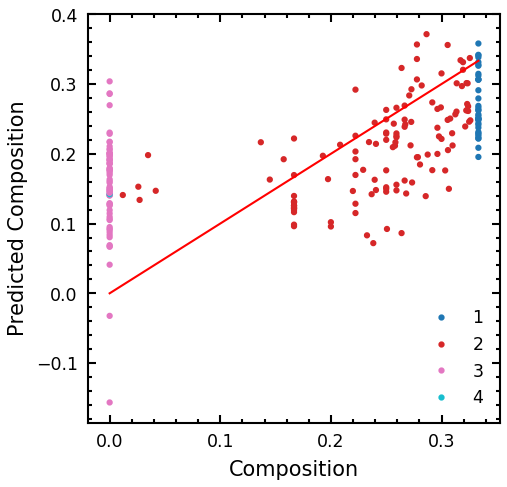

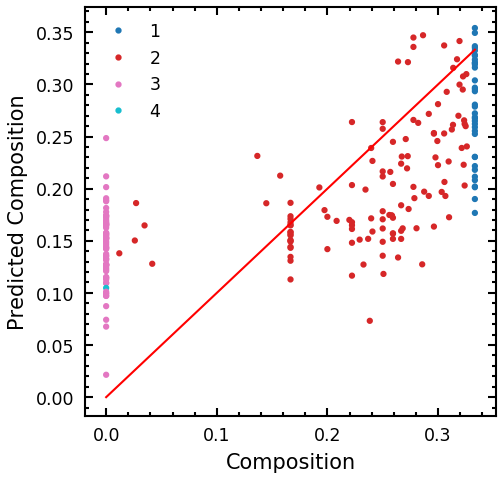

In [8]:
for cutoff in cutoffs:
    scatter = plt.scatter(
        iza_compositions, 
        iza_predicted_compositions[cutoff],
        c=iza_cantons, cmap='tab10'
    )
    plt.plot(
        [
            iza_compositions.min(), 
            iza_compositions.max()
        ], 
        [
            iza_compositions.min(), 
            iza_compositions.max()
        ], 
        c='r'
    )
    plt.xlabel(f'Composition')
    plt.ylabel(f'Predicted Composition')
    plt.legend(*scatter.legend_elements())
    plt.show()

-0.5288676465562073 0.4888644820258491
1521 591


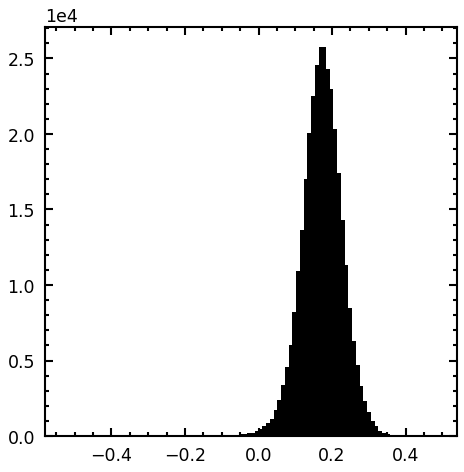

-0.10140842315623677 0.46448346745651686
7 362


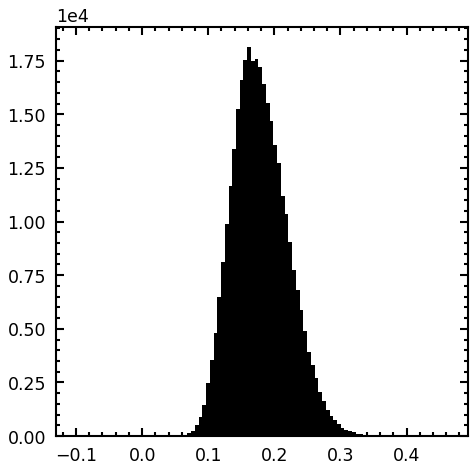

In [12]:
for cutoff in cutoffs:
    predicted_deem_compositions = np.loadtxt(
        f'../../Processed_Data/DEEM_330k/Data/{cutoff}/LRR/Composition/lr_structure_properties.dat'
    )
    print(np.amin(predicted_deem_compositions), np.amax(predicted_deem_compositions))
    print(np.count_nonzero(predicted_deem_compositions < 0.0), np.count_nonzero(predicted_deem_compositions > 1/3))
    plt.hist(predicted_deem_compositions, bins=100)
    plt.show()